In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import math
import matplotlib.pyplot as plt
import os, sys, re
from PIL import Image                                 #create image from array
from datetime import datetime                         #date for submission file
from  scipy import ndimage                            #for image rotation
from sklearn.preprocessing import normalize           #for normailzation

import tensorflow as tf

# CNN libraries (keras) for neural networks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ModelCheckpoint

# additional libraries
import matplotlib.pyplot as plt
import cv2

%load_ext autoreload
%autoreload 2

#For Google Colab
#from google.colab import drive
#drive.mount('/content/gdrive')

Using TensorFlow backend.


### 0) Parameters

In [16]:
SEED = 1642
PATCH_SIZE = 16
NUMBER_TRAIN_IMG = 1 # max 100
ROOT = './'
DATA_ROOT_DIR = ROOT+ "Datasets/"
SUBMISSION_DIR = ROOT + "Submissions/"
PREDICTION_DIR = ROOT + "Predictions/"
CHECKPOINT_DIR = ROOT + 'Checkpoints/'
CONTEXT = 16
NB_CLASSES = 2
NB_EPOCHS = 1
BATCH_SIZE = 75

np.random.seed(SEED)  # for reproducibility

### 1) Functions

In [9]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def LoadTrainingData(n_img, rootdir="Datasets/training/", printnames=False):
    """ Load the data from the root directory. (a total of n_img images) """

    image_dir = rootdir + "images/"
    files = os.listdir(image_dir)

    n = min(n_img, len(files)) # Load maximum 20 images
    print("Loading " + str(n) + " train images...")
    imgs = [load_image(image_dir + files[i]) for i in range(n)]

    gt_dir = rootdir + "groundtruth/"
    print("Loading " + str(n) + " groundtruth images...")
    gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

    if (printnames):
        print("The loaded images are: ")
        for i in range(n):
            print("    - " + files[i])
    
    return imgs, gt_imgs

def DataAugmentation(imgs, gt_imgs, angles, sym=False, printinfo=False):
    """
    Augments the data by rotating the image with the angles given in the list <angles>.
    If <sym> is true, it also augments the the data with the images obtained by performing a
    y axis symmetry.
    
    The augmented data will present itself as follows: 
        
        [angles[1] rotations, ..., angles[end] rotations,
        Y axis symmetry of the angles[1] rotations, ..., Y axis symmetry of the angles[end] rotations]
 
    """
    n = len(imgs)
    
    # Creating the augmented version of the images.
    aug_imgs = []
    aug_gt_imgs = []
    
    # Rotating the images and adding them to the augmented data list
    for theta in angles:
        if (printinfo):
            print("Augmenting the data with the images rotated by", theta , "deg.")
        aug_imgs += [BuildRotatedImage(imgs[i], theta) for i in range(n)]
        aug_gt_imgs += [BuildRotatedImage(gt_imgs[i], theta) for i in range(n)]  
        
    # Y symmetry of the images and adding them to the augmented dat list
    if (sym):
        if (printinfo):
            print("Augmenting the data with the symmetries")
        n_tmp = len(aug_imgs)
        aug_imgs += [np.flip(aug_imgs[i],1) for i in range(n_tmp)]
        aug_gt_imgs += [np.flip(aug_gt_imgs[i],1) for i in range(n_tmp)]
        
    return aug_imgs, aug_gt_imgs


def BuildExtendedImage(img, pad):
    """ Create a 3x3 grid of the imput image by mirroring it at the boundaries"""
    
    ext_img = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_REFLECT) 

    return ext_img

def BuildRotatedImage(img, degree):
    """ Return the same image rataded by <degree> degrees. The corners are filled using mirrored boundaries. """
    
    # Improving performance using existing functions for specific angles
    if (degree==0):
        return img
    elif (degree==90):
        return np.rot90(img)
    elif (degree==180):
        return np.rot90(np.rot90(img))
    elif (degree==270):
        return np.rot90(np.rot90(np.rot90(img)))
    else:
        h = img.shape[0]
        w = img.shape[1]

        padh = math.ceil(h/4)
        padw = math.ceil(w/4)
        pad = max(padh, padw)


        # Extend and rotate the image
        ext_img = BuildExtendedImage(img, pad)
        rot_img = ndimage.rotate(ext_img, degree, reshape=False)

        # Taking care of nummerical accuracies (not sure where they come from)

        rot_img[rot_img<0] = 0.0
        rot_img[rot_img>1] = 1.0

        # Crop the image
        if (len(img.shape) > 2):
            rot_img = rot_img[pad:pad+h, pad:pad+w, :]
        else:
            rot_img = rot_img[pad:pad+h, pad:pad+w]
        
        return rot_img

def img_crop(im, w, h, c=0):
    """ Personalized version of the img_crop incorporating the option of getting the context (c) around the pataches"""
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    
    # padding the image to access the context of border patches
    if is_2d:
        pad_im = np.pad(im,((c,c),(c,c)), 'reflect')
    else:
        pad_im = np.pad(im,((c,c),(c,c),(0,0)), 'reflect')

    # cropping the image
    for i in range(c,imgheight+c,h):
        for j in range(c,imgwidth+c,w):
            if is_2d:
                im_patch = pad_im[j-c:(j+w)+c, i-c:(i+h)+c]
            else:
                im_patch = pad_im[j-c:(j+w)+c, i-c:(i+h)+c, :]

            list_patches.append(im_patch)
    return list_patches

def ExtractTrainPatch(imgs, gt_imgs, context=0, balancing=True):
    """ Extract patches of size patch_size from the input images.  """ 
    n = len(imgs)
    
    img_patches = [img_crop(imgs[i], PATCH_SIZE, PATCH_SIZE, context) for i in range(n)]
    gt_patches = [img_crop(gt_imgs[i], PATCH_SIZE, PATCH_SIZE) for i in range(n)]

    # Linearize list of patches
    
    X = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    Y = np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    
    return X, Y

def value_to_class(v, foreground_threshold):
    df = np.mean(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def PrintFeatureStatistics(X, Y):
    print('There are ' + str(X.shape[0]) + ' data points (patches)')
    print('The size of the patches is ' + str(X.shape[1]) + 'x' 
          + str(X.shape[2]) + ' = ' + str(X.shape[1]*X.shape[2]) +" pixels")

    print('Number of classes = ' + str(len(np.unique(Y))))

    Y0 = [i for i, j in enumerate(Y) if j == 0]
    Y1 = [i for i, j in enumerate(Y) if j == 1]
    print('Class 0 (background): ' + str(len(Y0)) + ' samples')
    print('Class 1 (signal): ' + str(len(Y1)) + ' samples')
    print('Proportion of road: ', len(Y1)/(len(Y1)+len(Y0)))
    print('Proportion of background: ', len(Y0)/(len(Y1)+len(Y0)))

def NormalizeFeatures(X):
    """Normalize X which must have shape (num_data_points,num_features)"""
    m = np.mean(X,axis=0)
    s = np.std(X,axis=0)
    
    return (X-m)/s

def Balancing(X_train, Y_train):
    c0 = 0  # bgrd
    c1 = 0  # road
    for i in range(len(Y_train)):
        if Y_train[i] == 0:
            c0 = c0 + 1
        else:
            c1 = c1 + 1
    print('Number of data points per class (before balancing): background = ' + str(c0) + ' road = ' + str(c1))

    print('Balancing training data...')
    min_c = min(c0, c1)
    idx0 = [i for i in range(len(Y_train)) if Y_train[i] == 0]
    idx1 = [i for i in range(len(Y_train)) if Y_train[i] == 1]
    indices = idx0[0:min_c] + idx1[0:min_c]
    new_indices = np.random.permutation(indices)
    
    X_balanced = X_train[new_indices]
    Y_balanced = Y_train[new_indices]

    c0 = 0
    c1 = 0
    for i in range(len(Y_balanced)):
        if Y_balanced[i] == 0:
            c0 = c0 + 1
        else:
            c1 = c1 + 1
    print('Number of data points per class (after balancing): background = ' + str(c0) + ' road = ' + str(c1))
    
    return X_balanced, Y_balanced

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def TruePositiveRate(tX, Y, logregModel):
    """Compute the true positive rate of the lgistic regression model logregModel on 
       the training augmented data tX.
    """
    # Predict on the training set
    Y_pred = logregModel.predict(tX)
    
    # Get non-zeros in prediction and grountruth arrays
    Y_predn = np.nonzero(Y_pred)[0]
    Yn = np.nonzero(Y)[0]

    TPR = len(list(set(Yn) & set(Y_predn))) / float(len(Yn))
    return TPR
    
def Normalize(X, axis=(0,1,2)):

    m = np.mean(X, axis)
    s = np.std(X, axis)
    print("Mean before normalization: ", m)
    print("Std before normalization: ", s)

    X_norm = (X - m)/s
    print("Mean after normalization: ", np.mean(X_norm, axis))
    print("Std after normalization: ", np.std(X_norm, axis))
    return X_norm


def PlotHistory(history):
    # Plot training & validation accuracy values

    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    score = model.evaluate(X_tr, Y_tr, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

def VisualizeCNNPrediction(CNNModel, img_ind):
    
    test_rootdir = DATA_ROOT_DIR + "test_set_images/"
    test_files = os.listdir(test_rootdir)
    img_path = test_rootdir + test_files[img_ind] + "/" + test_files[img_ind] + ".png"
    
    img = load_image(img_path)
    Xi = ExtractTestPatch(img, CONTEXT)
    Yi_prob = CNNModel.predict(Xi, verbose=0)
    Yi_pred = np.argmax(Yi_prob, axis=1)
    print("Number of predicted road patches: ", Yi_pred.sum())
    # Display prediction as an image

    w = img.shape[0]
    h = img.shape[1]
    predicted_im = label_to_img(w, h, PATCH_SIZE, PATCH_SIZE, Yi_pred)
    cimg = make_img_overlay(img, predicted_im)
    fig1, ax = plt.subplots(figsize=(8, 4)) 
    ax.set_title("CNN prediction")
    ax.imshow(cimg, cmap='Greys_r')

def binary_to_uint8(img):
    rimg = (img * 255).round().astype(np.uint8)
    return rimg

def reconstruct_from_labels(image_id, submissionfile):
    im = np.zeros((imgwidth, imgheight), dtype=np.uint8)
    f = open(submissionfile)
    lines = f.readlines()
    image_id_str = "%.3d_" % image_id
    for i in range(1, len(lines)):
        line = lines[i]
        if not image_id_str in line:
            continue

        tokens = line.split(",")
        id = tokens[0]
        prediction = int(tokens[1])
        tokens = id.split("_")
        i = int(tokens[1])
        j = int(tokens[2])

        je = min(j + w, imgwidth)
        ie = min(i + h, imgheight)
        if prediction == 0:
            adata = np.zeros((w, h))
        else:
            adata = np.ones((w, h))

        im[j:je, i:ie] = binary_to_uint8(adata)

    Image.fromarray(im).save("prediction_" + "%.3d" % image_id + ".png")

    return im

def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i : i + patch_size, j : j + patch_size]
            label = patch_to_label(patch)
            yield ("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, "w") as f:
        f.write("id,prediction\n")
        for fn in image_filenames:
            f.writelines("{}\n".format(s) for s in mask_to_submission_strings(fn))


def ExtractTestPatch(img, context=0):
    """ Extract patches of size patch_size from the input image.""" 


    img_patches = img_crop(img, PATCH_SIZE, PATCH_SIZE, context)
    
    # Linearize list of patches
    img_patches = np.asarray([img_patches[i]
                              for i in range(len(img_patches))])
    return img_patches

def CreateSubmission(CNNmodel):
    """ Create a submission file using the trained logregModel."""
    # paths
    test_rootdir = DATA_ROOT_DIR + "test_set_images/"
    test_files = os.listdir(test_rootdir)
    
    prediction_filenames = []
    
    # Prediction of all the test images
    for i  in range(len(test_files)):
        print("Predicting image" + test_files[i] + "...")
        # Image path of the i-th image
        img_path = test_rootdir + test_files[i] + "/" + test_files[i] + ".png"
        
        # Extraction of the data feature
        img = load_image(img_path)
        Xi = ExtractTestPatch(img, CONTEXT)
        
        # Prediction of the i-th image using the trained model logregModel
        Yi_prob = CNNmodel.predict(Xi, verbose=0)
        Yi_pred = np.argmax(Yi_prob, axis=1)
        
        # Construction of the mask
        w = img.shape[0]
        h = img.shape[1]
        predicted_mask = label_to_img(w, h, PATCH_SIZE, PATCH_SIZE, Yi_pred)
        
        # Creating the name for the predicted mask
        img_id = int(re.search(r"\d+", test_files[i]).group(0))
        prediction_filenames += [PREDICTION_DIR + "prediction_" + "%.3d" % img_id + ".png"]
        
        # Saving the masks in the preddir folder
        Image.fromarray(binary_to_uint8(predicted_mask)).save(prediction_filenames[i])  
    
    # Create unique filename
    now = datetime.now()
    dt_string = now.strftime('%H_%M-%d_%m')

    # Create a folder in the submssion directory and save the submission and the model in it
    os.mkdir(SUBMISSION_DIR + dt_string)
    model.save(SUBMISSION_DIR + dt_string + '/' + 'model.h5')

    submission_filename = SUBMISSION_DIR  + dt_string + '/' + 'submission_CNN_' + dt_string + '.csv'
    
    # Create submission
    print("Creating submission file...")
    masks_to_submission(submission_filename, prediction_filenames)

### 1) Loading the set of images

In [10]:
traindir = DATA_ROOT_DIR + "training/"
imagedir = traindir + "images/"

# list with all the available images name
files = os.listdir(imagedir) 

n = NUMBER_TRAIN_IMG
imgs, gt_imgs = LoadTrainingData(n, traindir)

Loading 1 train images...
Loading 1 groundtruth images...


### 2) Data augmentation

In [11]:
# Augmenting the data
angles = [0, 45]
aug_imgs, aug_gt_imgs = DataAugmentation(imgs, gt_imgs, angles, sym=False, printinfo=True)

print("(Augmented) number of images (and groundtruth): ", len(aug_imgs))

#uncomment to see an image
#plt.imshow(aug_imgs[5], cmap='Greys_r')

Augmenting the data with the images rotated by 0 deg.
Augmenting the data with the images rotated by 45 deg.
(Augmented) number of images (and groundtruth):  2


### 3) Extract patches

In [12]:
img_patches, gt_patches = ExtractTrainPatch(aug_imgs, aug_gt_imgs, context=CONTEXT, balancing=True)

print("img_patches has size ", img_patches.shape)
print("gt_patches has size ", gt_patches.shape)

del aug_imgs, aug_gt_imgs

img_patches has size  (1250, 48, 48, 3)
gt_patches has size  (1250, 16, 16)


### 4) Extract features

In [13]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

#X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
X_tr_raw = np.copy(img_patches)
Y_tr_raw = np.asarray([value_to_class(gt_patches[i], foreground_threshold) for i in range(len(gt_patches))])

# Balancing the data
X_tr_bal, Y_tr_bal = Balancing(X_tr_raw, Y_tr_raw)

# Convert class vectors to binary class matrices
Y_tr = np_utils.to_categorical(Y_tr_bal, NB_CLASSES)
X_tr = np.copy(X_tr_bal).astype('float32')

# Print feature statistics
PrintFeatureStatistics(X_tr_bal, Y_tr_bal)

#Deleting unused variables
del X_tr_bal, Y_tr_bal, X_tr_raw, Y_tr_raw

Number of data points per class (before balancing): background = 970 road = 280
Balancing training data...
Number of data points per class (after balancing): background = 280 road = 280
There are 560 data points (patches)
The size of the patches is 48x48 = 2304 pixels
Number of classes = 2
Class 0 (background): 280 samples
Class 1 (signal): 280 samples
Proportion of road:  0.5
Proportion of background:  0.5


### 5) CNN model definition

In [14]:
# size of pooling area for max pooling
pool_size = (2, 2)

# input size
input_shape = (X_tr.shape[1], X_tr.shape[2], X_tr.shape[3])

#Reseting the network
K.clear_session()
model = Sequential()

model.add(Convolution2D(64, (7, 7), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, (5, 5), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['categorical_accuracy'])

model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        9472      
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        3

### 6) CNN model training

In [18]:
checkpoint = ModelCheckpoint(CHECKPOINT_DIR + 'model.hdf5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)

history = model.fit(X_tr, Y_tr, batch_size=BATCH_SIZE, epochs=NB_EPOCHS, validation_split = 0.2, callbacks=[checkpoint])

Train on 448 samples, validate on 112 samples
375/448 [========================>.....] - ETA: 4s - loss: 0.6931 - categorical_accuracy: 0.4880
Epoch 00001: val_categorical_accuracy improved from -inf to 0.56250, saving model to ./Checkpoints/model.hdf5
448/448 [==============================] - 26s 59ms/sample - loss: 0.6932 - categorical_accuracy: 0.4933 - val_loss: 0.6929 - val_categorical_accuracy: 0.5625


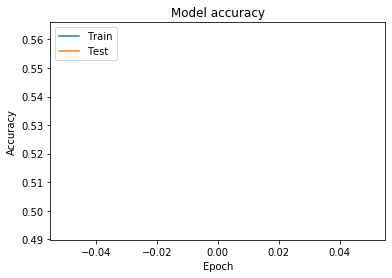

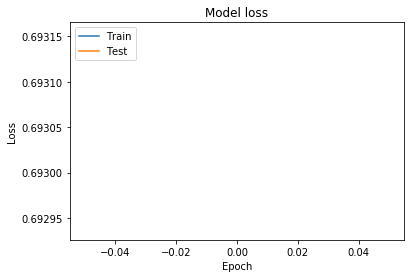

Test score: 0.6930097835404533
Test accuracy: 0.5642857


In [19]:
# Training history
PlotHistory(history)

In [20]:
# Create submission
CreateSubmission(model)

Predicting imagetest_13...
Predicting imagetest_14...


KeyboardInterrupt: 

In [ ]:
# Visualize a prediction
VisualizeCNNPrediction(model, 12)